#NEURAL NETWORKS AND DEEP LEARNING

---
A.A. 2021/22 (6 CFU) - Dr. Alberto Testolin, Dr. Umberto Michieli
---


## Lab. 05 - Convolutional Autoencoder

An autoencoder, in general, is a network that is trained to attempt to copy its input to its output. Internally, it has a **latent space** that describes a code used to represent the input. The network may be viewed as consisting of two parts: an **encoder** function $h=f(x)$ and a **decoder** that produces a reconstruction $r=g(h)$.

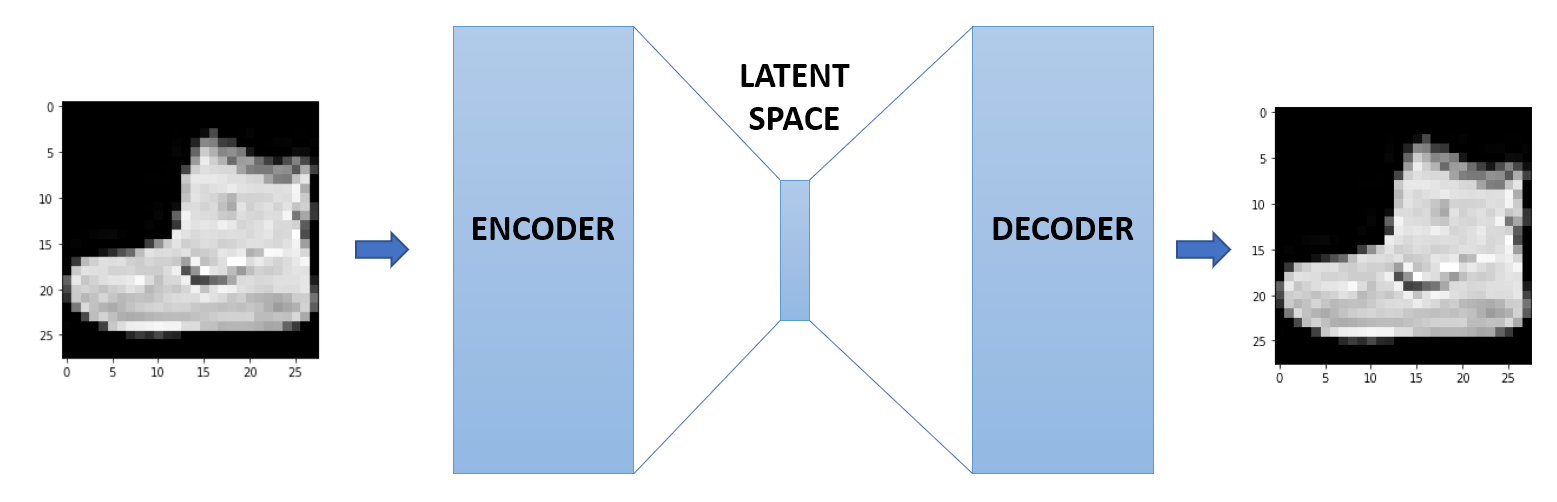

The learning process is described simply as minimizing a loss function $L(x, g(f(x)))$, where $L$ is a loss function penalizing $g(f(x))$ for being dissimilar from $x$, such as the mean squared error.

While the learning is considered to be **unsupervised** since we are using only the value of $x$, the actual implementation is similar to a supervised setting where the label is just derived from the input.

In [1]:
# !pip install numpy
# !pip pip3 install torch torchvision torchaudio
# !pip install tqdm
# !pip install matplotlib
# !pip install scikit-image
# !pip install scipy
# !pip install scikit-learn
# !pip install pandas
# !pip install seaborn
# !pip install sklearn
# !pip install tensorboard
 

In [2]:
import matplotlib.pyplot as plt # plotting library
import numpy as np # this module is useful to work with numerical arrays
import pandas as pd # this module is useful to work with tabular data
import random # this module will be used to select random samples from a collection
import os # this module will be used just to create directories in the local filesystem
from tqdm import tqdm # this module is useful to plot progress bars

import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader
from torch import nn

# Dataset

## Define the dataset

For this lab. we will use one of the dataset already included in PyTorch ([https://pytorch.org/vision/stable/datasets.html](https://pytorch.org/vision/stable/datasets.html)).

**NOTE:** These dataset do not require the definition of a custom `Dataset` class, so we can focus on the network implementation.

The Fashion MNIST dataset is a colletion of Zalando's article images. The size of the images is $28 \times 28$, and there is a single channel only (black and white images) with 10 classes.

In [3]:
### Download the data and create dataset
data_dir = 'dataset'
# With these commands the train and test datasets, respectively, are downloaded 
# automatically and stored in the local "data_dir" directory.
train_dataset = torchvision.datasets.FashionMNIST(data_dir, train=True, download=True)
test_dataset  = torchvision.datasets.FashionMNIST(data_dir, train=False, download=True)

The output of the dataset is a PIL Image, a standard format for image processing, but we can easily convert the data to a numpy array:
```
image_numpy = np.array(pil_image)
```
or to a PyTorch tensor:
```
to_tensor = torchvision.transforms.ToTensor()
image_tensor = to_tensor(pil_image)
```


Let's plot some random samples from the dataset. The first element of the sample is the actual image, while the second is the corresponding label.

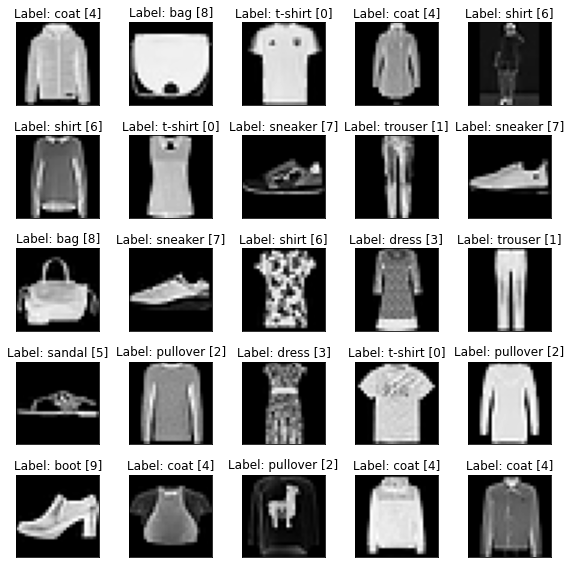

In [4]:
### Plot some sample
label_names=['t-shirt','trouser','pullover','dress','coat','sandal','shirt',
             'sneaker','bag','boot']
fig, axs = plt.subplots(5, 5, figsize=(8,8))
for ax in axs.flatten():
    # random.choice allows to randomly sample from a list-like object (basically anything that can be accessed with an index, like our dataset)
    img, label = random.choice(train_dataset)
    ax.imshow(np.array(img), cmap='gist_gray')
    ax.set_title(f'Label: {label_names[label]} [{label}]')
    ax.set_xticks([])
    ax.set_yticks([])
plt.tight_layout()

## Define the dataset transform

In this example we are using the input images without any modification. As always, the only requirement is to transform the input data to tensors of the proper shape.

In [5]:
# In this case the train_transform and test_transform are the same, 
# but we keep them separate for potential future updates
train_transform = transforms.Compose([
    transforms.ToTensor(),
])
test_transform = transforms.Compose([
    transforms.ToTensor(),
])


Since we already defined our datasets, this is an alternative (and recommended) way to add (or modify) a dataset transformation without reinitializing the dataset (very useful when the dataset initialization is slow):

In [6]:
# check what is going on BEFORE the transformation is in place!
print(train_dataset)
print(train_dataset[0])
print(train_dataset[0][0])
print(train_dataset[0][1])

Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: dataset
    Split: Train
(<PIL.Image.Image image mode=L size=28x28 at 0x7F170A71BFD0>, 9)
<PIL.Image.Image image mode=L size=28x28 at 0x7F170A721190>
9


In [7]:
# Set the train transform
train_dataset.transform = train_transform
# Set the test transform
test_dataset.transform = test_transform

In [8]:
# check what is going on AFTER the transformation is in place!
print(train_dataset)
print(train_dataset[0])
print(train_dataset[0][0])
print(train_dataset[0][1])

Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: dataset
    Split: Train
(tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000,

## Define the dataloader

The dataloader allows to easily create batch of data, in this case we set a batch size of 256, and we also enable data shuffling for the training dataset.

In [9]:
### Define train dataloader
train_dataloader = DataLoader(train_dataset, batch_size=256, shuffle=True)
### Define test dataloader
test_dataloader = DataLoader(test_dataset, batch_size=256, shuffle=False)


batch_data, batch_labels = next(iter(train_dataloader))
print(f"TRAIN BATCH SHAPE")
print(f"\t Data: {batch_data.shape}")
print(f"\t Labels: {batch_labels.shape}")

batch_data, batch_labels = next(iter(test_dataloader))
print(f"TEST BATCH SHAPE")
print(f"\t Data: {batch_data.shape}")
print(f"\t Labels: {batch_labels.shape}")

TRAIN BATCH SHAPE
	 Data: torch.Size([256, 1, 28, 28])
	 Labels: torch.Size([256])
TEST BATCH SHAPE
	 Data: torch.Size([256, 1, 28, 28])
	 Labels: torch.Size([256])


# Autoencoder

## Encoder

Let's start from the encoder. In the figure you can find a suggested architecture for the encoder, with all the required parameters for each layer.

In this example we are considering a latent space with just **2 variables**, so make sure your encoder generates tensors with the proper shape.

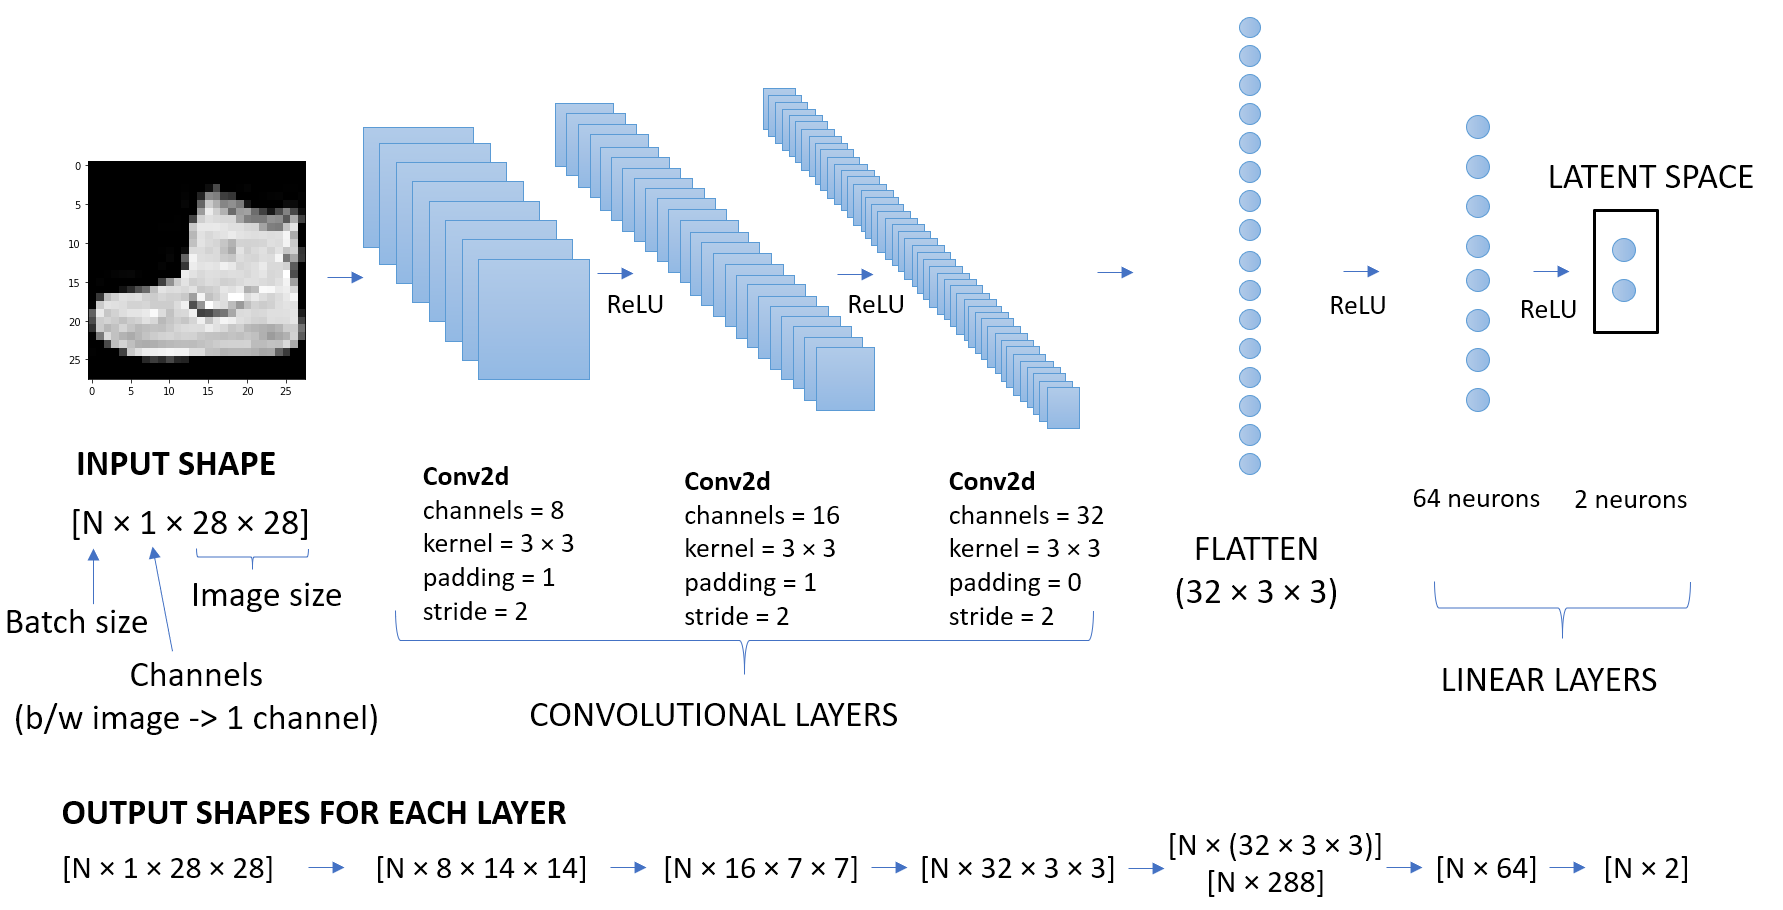

`torch.nn.Sequential` is a utility function that allows to easily concatenate sequential layers, without defining a separate object for each of them (more details here: [torch.nn.Sequential](https://pytorch.org/docs/stable/generated/torch.nn.Sequential.html)).

The output of a convolutional layer is typically multi-dimensional. To apply a linear layer after a convolutional one you should convert your tensor to a monodimensional array. This operation is often referred to as **flattening**. In PyTorch, this can be done with the [`torch.nn.Flatten`](https://pytorch.org/docs/stable/generated/torch.nn.Flatten.html?highlight=flatten#torch.nn.Flatten)
 layer. By setting `start_dim = 1` we keep the first axis (index 0) as it is (which represents the batch size in our case, that should not be flattened) and all the other axes will be flattened in the new second axis.


In [10]:
# TODO: fill the holes with the number from the above figure.

class Encoder(nn.Module):
    
    def __init__(self, encoded_space_dim):
        super().__init__()
        
        ### Convolutional section
        self.encoder_cnn = nn.Sequential(
            # First convolutional layer
            nn.Conv2d(in_channels= 1, out_channels=8, kernel_size=3, 
                      stride=2, padding=1),
            nn.ReLU(True),
            # Second convolutional layer
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, 
                      stride=2, padding=1),
            nn.ReLU(True),
            # Third convolutional layer
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, 
                      stride=2, padding=0),
            nn.ReLU(True)
        )
        
        ### Flatten layer
        self.flatten = nn.Flatten(start_dim=1)

        ### Linear section
        self.encoder_lin = nn.Sequential(
            # First linear layer

            nn.Linear(in_features=32*3*3, out_features=64),
            nn.ReLU(True),
            # Second linear layer
            nn.Linear(in_features=64, out_features=2)
        )
        
    def forward(self, x):
        # Apply convolutions
        x = self.encoder_cnn(x)
        # Flatten
        x = self.flatten(x)
        # # Apply linear layers
        x = self.encoder_lin(x)
        return x

## Decoder

Typically the structure of the decoder is specular with respect to the encoder, but this is not a strict requirement. Some successful implementations use very different architectures for the encoder and the decoder. 

The only requirement of the decoder is the input shape, which must match the latent space, and the output shape, that must match the input image. 

In this example we implement a decoder perfectly matched with the encoder architecture, but reversed.

Since the convolutional layers in the encoder perform a down-scaling, we need up-scaling layers in the decoder. To this end we use **transposed convolutions**, already available in PyTorch with the [`torch.nn.ConvTranspose2d`](https://pytorch.org/docs/stable/generated/torch.nn.ConvTranspose2d.html) layer.

Similarly to the `torch.nn.Flatten` layer, the [`torch.nn.Unflatten`](https://pytorch.org/docs/stable/generated/torch.nn.Unflatten.html?highlight=unflatten#torch.nn.Unflatten) layer does the opposite operation. We take the axis at index 1 (`dim=1`) and we reshape it to the proper shape (`unflattened_size=(32, 3, 3)`).

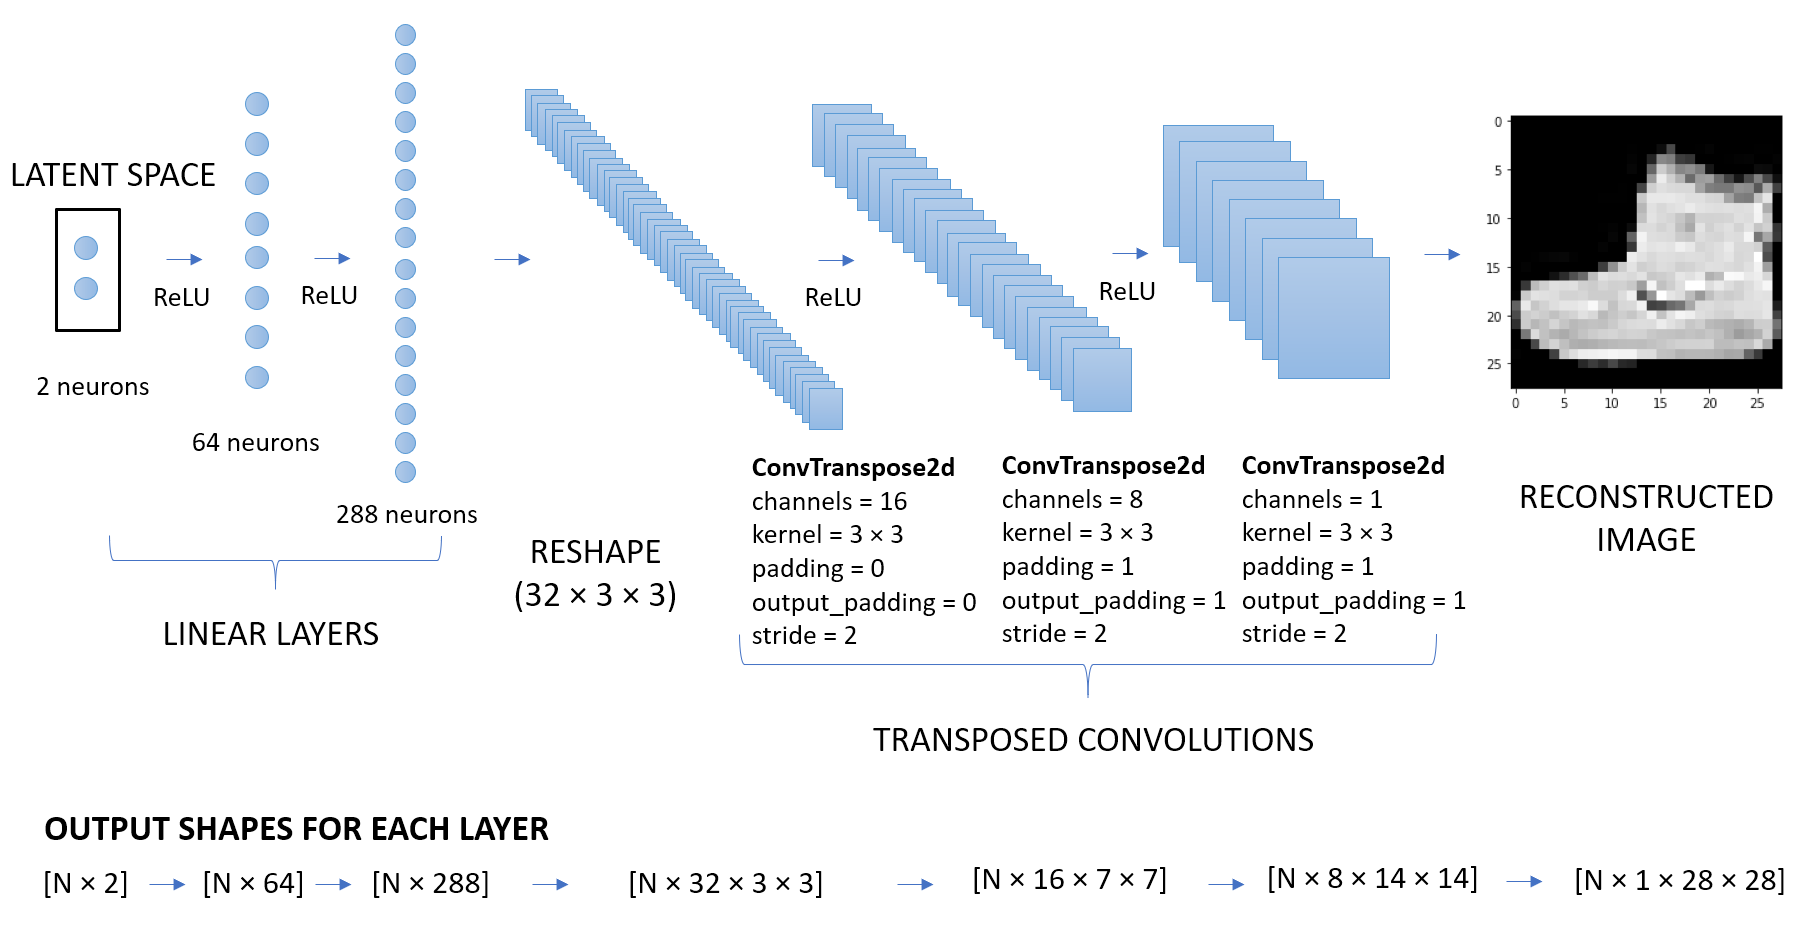

In [11]:
# TODO: fill the holes with the number from the above figure.

class Decoder(nn.Module):
    
    def __init__(self, encoded_space_dim):
        super().__init__()

        ### Linear section
        self.decoder_lin = nn.Sequential(
            # First linear layer
            nn.Linear(in_features=2, out_features=64),
            nn.ReLU(True),
            # Second linear layer
            nn.Linear(in_features=64, out_features=3*3*32),
            nn.ReLU(True)
        )

        ### Unflatten
        self.unflatten = nn.Unflatten(dim=1, unflattened_size=(32, 3, 3))

        ### Convolutional section
        self.decoder_conv = nn.Sequential(
            # First transposed convolution
            nn.ConvTranspose2d(in_channels=32, out_channels=16, kernel_size=3, 
                               stride=2, output_padding=0),
            nn.ReLU(True),
            # Second transposed convolution
            nn.ConvTranspose2d(in_channels=16, out_channels=8, kernel_size=3, 
                               stride=2, padding=1, output_padding=1),
            nn.ReLU(True),
            # Third transposed convolution
            nn.ConvTranspose2d(in_channels=8, out_channels=1, kernel_size=3, 
                               stride=2, padding=1, output_padding=1)
        )
        
    def forward(self, x):
        # Apply linear layers
        x = self.decoder_lin(x)
        # Unflatten
        x = self.unflatten(x)
        # Apply transposed convolutions
        x = self.decoder_conv(x)
        # Apply a sigmoid to force the output to be between 0 and 1 (valid pixel values)
        x = torch.sigmoid(x)
        return x

Initialize the two networks.

In [12]:
### Set the random seed for reproducible results
torch.manual_seed(0)

### Initialize the two networks
encoded_space_dim = 2
encoder = Encoder(encoded_space_dim=encoded_space_dim)
decoder = Decoder(encoded_space_dim=encoded_space_dim)

Let's check if all the shapes are correct.

In [13]:
### Some examples
# Take an input image (remember to add the batch dimension)
img, _ = test_dataset[0]
img = img.unsqueeze(0) # Add the batch dimension in the first axisfig.savefig('autoencoder_progress_%d_features/epoch_%d.jpg' % (encoded_space_dim, epoch + 1))
print('Original image shape:', img.shape)
# Encode the image
img_enc = encoder(img)
print('Encoded image shape:', img_enc.shape)
# Decode the image
dec_img = decoder(img_enc)
print('Decoded image shape:', dec_img.shape)

Original image shape: torch.Size([1, 1, 28, 28])
Encoded image shape: torch.Size([1, 2])
Decoded image shape: torch.Size([1, 1, 28, 28])


# Training

The training is similar to the previous examples. The only difference is that now we have 2 different networks. In this situation you have 2 choices:
*   Use a single optimizer to train the parameters of both networks.
*   Define a separate optimizer for each network, and update both of them in the training loop.

In this case we define a single optimizer for both networks, by just providing a list of the required parameters to the optimizer (see the code below).

You can find more details for all the possible scenarios [here](https://pytorch.org/docs/stable/optim.html).

In [14]:
### Define the loss function
loss_fn = torch.nn.MSELoss()

### Define an optimizer (both for the encoder and the decoder!)
lr = 5e-4 # Learning rate
params_to_optimize = [
    {'params': encoder.parameters()},
    {'params': decoder.parameters()}
]
optim = torch.optim.Adam(params_to_optimize, lr=lr, weight_decay=1e-5)

# Check if the GPU is available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Selected device: {device}')

# Move both the encoder and the decoder to the selected device
encoder.to(device)
decoder.to(device)

# IF THIS CELL GIVES CUDA ERROR, OUT OF MEMORY, REBOOT TO FIX IT

Selected device: cuda


Decoder(
  (decoder_lin): Sequential(
    (0): Linear(in_features=2, out_features=64, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=64, out_features=288, bias=True)
    (3): ReLU(inplace=True)
  )
  (unflatten): Unflatten(dim=1, unflattened_size=(32, 3, 3))
  (decoder_conv): Sequential(
    (0): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(2, 2))
    (1): ReLU(inplace=True)
    (2): ConvTranspose2d(16, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): ConvTranspose2d(8, 1, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  )
)

## Training function

For a cleaner and more reusable code, we define a training and a testing funcion. This will make the training loop more compact and readable.

The function will train (and test) the network just **for a single epoch**.

In this case, we just track the training loss for each batch. If you want the training loss for the entire epoch, you have to concatenate all the outputs (see the testing function as reference for this case).

In [15]:
### Training function
def train_epoch(encoder, decoder, device, dataloader, loss_fn, optimizer):
    # Set train mode for both the encoder and the decoder
    encoder.train()
    decoder.train()
    # Iterate the dataloader (we do not need the label values, this is unsupervised learning)
    for image_batch, _ in dataloader: # with "_" we just ignore the labels (the second element of the dataloader tuple)
        # Move tensor to the proper device
        image_batch = image_batch.to(device)
        # Encode data
        encoded_data = encoder(image_batch)
        # Decode data
        decoded_data = decoder(encoded_data)
        # Evaluate loss
        loss = loss_fn(decoded_data, image_batch)
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Print batch loss
        print('\t partial train loss (single batch): %f' % (loss.data))

## Testing function

In this case, the testing function has the only goal to evaluate how well we are reproducing the input. We quantify this with the average MSE of the entire test set (which in this case correspond to our loss function, but this is not always true).

Since the entire dataset does not always fit in memory, this example shows how to evaluate the network output in batches, aggregating the results (using `conc_out` and `conc_label` in the code). At the end, you can evaluate a  single overall loss.

In [16]:
### Testing function
def test_epoch(encoder, decoder, device, dataloader, loss_fn):
    # Set evaluation mode for encoder and decoder
    encoder.eval()
    decoder.eval()
    with torch.no_grad(): # No need to track the gradients
        # Define the lists to store the outputs for each batch
        conc_out = []
        conc_label = []
        for image_batch, _ in dataloader:
            # Move tensor to the proper device
            image_batch = image_batch.to(device)
            # Encode data
            encoded_data = encoder(image_batch)
            # Decode data
            decoded_data = decoder(encoded_data)
            # Append the network output and the original image to the lists
            conc_out.append(decoded_data.cpu())
            conc_label.append(image_batch.cpu())
        # Create a single tensor with all the values in the lists
        conc_out = torch.cat(conc_out)
        conc_label = torch.cat(conc_label) 
        # Evaluate global loss
        val_loss = loss_fn(conc_out, conc_label)
    return val_loss.data

## Training loop

Now that we have the training and testing functions, the training loop is considerably simplified. We just need to call these 2 functions for `num_epochs` times.

To see what happen during the training, we also show the output corresponding to a specific image at the end of each epoch.

EPOCH 1/10
	 partial train loss (single batch): 0.179494
	 partial train loss (single batch): 0.181603
	 partial train loss (single batch): 0.180025
	 partial train loss (single batch): 0.178158
	 partial train loss (single batch): 0.182383
	 partial train loss (single batch): 0.177239
	 partial train loss (single batch): 0.178596
	 partial train loss (single batch): 0.177731
	 partial train loss (single batch): 0.178102
	 partial train loss (single batch): 0.174652
	 partial train loss (single batch): 0.179585
	 partial train loss (single batch): 0.180975
	 partial train loss (single batch): 0.173913
	 partial train loss (single batch): 0.174123
	 partial train loss (single batch): 0.174520
	 partial train loss (single batch): 0.175449
	 partial train loss (single batch): 0.178706
	 partial train loss (single batch): 0.176363
	 partial train loss (single batch): 0.176311
	 partial train loss (single batch): 0.179125
	 partial train loss (single batch): 0.175773
	 partial train loss (s

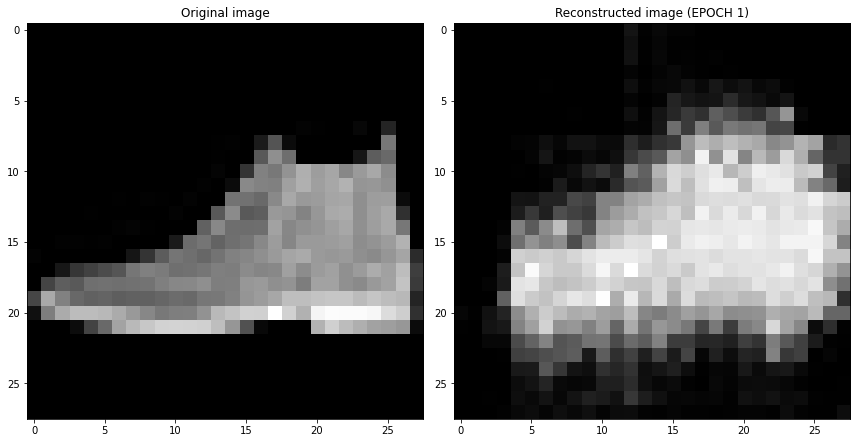

EPOCH 2/10
	 partial train loss (single batch): 0.063253
	 partial train loss (single batch): 0.061285
	 partial train loss (single batch): 0.063020
	 partial train loss (single batch): 0.057895
	 partial train loss (single batch): 0.061749
	 partial train loss (single batch): 0.059904
	 partial train loss (single batch): 0.060030
	 partial train loss (single batch): 0.059174
	 partial train loss (single batch): 0.058109
	 partial train loss (single batch): 0.059324
	 partial train loss (single batch): 0.059401
	 partial train loss (single batch): 0.057168
	 partial train loss (single batch): 0.060921
	 partial train loss (single batch): 0.058642
	 partial train loss (single batch): 0.058180
	 partial train loss (single batch): 0.061160
	 partial train loss (single batch): 0.059127
	 partial train loss (single batch): 0.058338
	 partial train loss (single batch): 0.056546
	 partial train loss (single batch): 0.059408
	 partial train loss (single batch): 0.058346
	 partial train loss (s

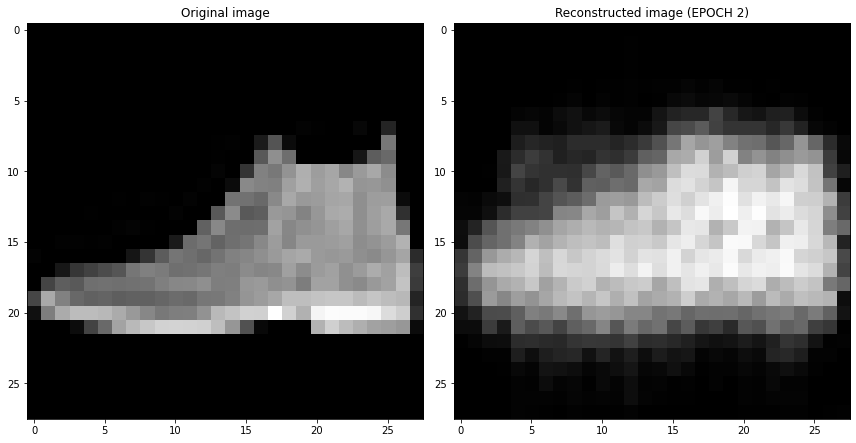

EPOCH 3/10
	 partial train loss (single batch): 0.041960
	 partial train loss (single batch): 0.041998
	 partial train loss (single batch): 0.042131
	 partial train loss (single batch): 0.042852
	 partial train loss (single batch): 0.041820
	 partial train loss (single batch): 0.040295
	 partial train loss (single batch): 0.044595
	 partial train loss (single batch): 0.042357
	 partial train loss (single batch): 0.043032
	 partial train loss (single batch): 0.039512
	 partial train loss (single batch): 0.042638
	 partial train loss (single batch): 0.042838
	 partial train loss (single batch): 0.040686
	 partial train loss (single batch): 0.043255
	 partial train loss (single batch): 0.043063
	 partial train loss (single batch): 0.043016
	 partial train loss (single batch): 0.040661
	 partial train loss (single batch): 0.042018
	 partial train loss (single batch): 0.040443
	 partial train loss (single batch): 0.042449
	 partial train loss (single batch): 0.041008
	 partial train loss (s

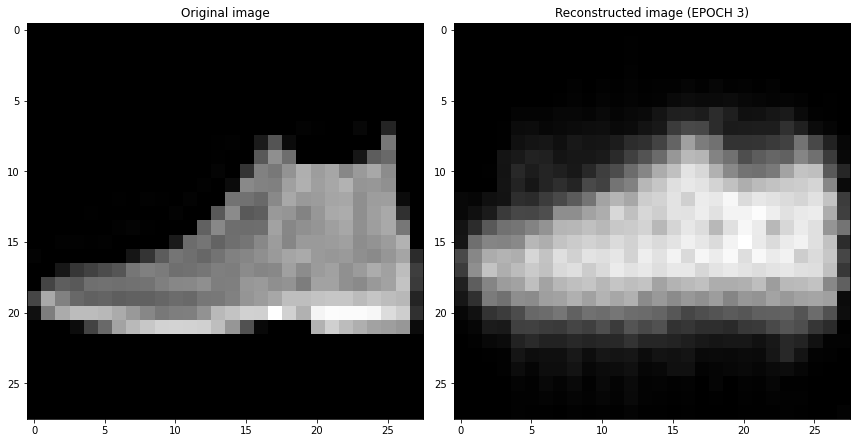

EPOCH 4/10
	 partial train loss (single batch): 0.039447
	 partial train loss (single batch): 0.039093
	 partial train loss (single batch): 0.039834
	 partial train loss (single batch): 0.038274
	 partial train loss (single batch): 0.038722
	 partial train loss (single batch): 0.038193
	 partial train loss (single batch): 0.037991
	 partial train loss (single batch): 0.040993
	 partial train loss (single batch): 0.038750
	 partial train loss (single batch): 0.036319
	 partial train loss (single batch): 0.040766
	 partial train loss (single batch): 0.037770
	 partial train loss (single batch): 0.036220
	 partial train loss (single batch): 0.041416
	 partial train loss (single batch): 0.039474
	 partial train loss (single batch): 0.040380
	 partial train loss (single batch): 0.039087
	 partial train loss (single batch): 0.039672
	 partial train loss (single batch): 0.037777
	 partial train loss (single batch): 0.040258
	 partial train loss (single batch): 0.036577
	 partial train loss (s

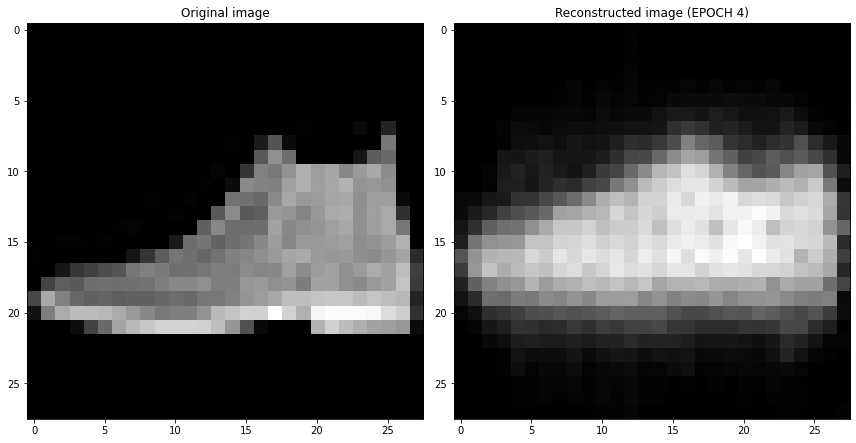

EPOCH 5/10
	 partial train loss (single batch): 0.036354
	 partial train loss (single batch): 0.037356
	 partial train loss (single batch): 0.035986
	 partial train loss (single batch): 0.037178
	 partial train loss (single batch): 0.039068
	 partial train loss (single batch): 0.037719
	 partial train loss (single batch): 0.036409
	 partial train loss (single batch): 0.037895
	 partial train loss (single batch): 0.038767
	 partial train loss (single batch): 0.037181
	 partial train loss (single batch): 0.039620
	 partial train loss (single batch): 0.038765
	 partial train loss (single batch): 0.036385
	 partial train loss (single batch): 0.035179
	 partial train loss (single batch): 0.035942
	 partial train loss (single batch): 0.038817
	 partial train loss (single batch): 0.036412
	 partial train loss (single batch): 0.038101
	 partial train loss (single batch): 0.041944
	 partial train loss (single batch): 0.038685
	 partial train loss (single batch): 0.036951
	 partial train loss (s

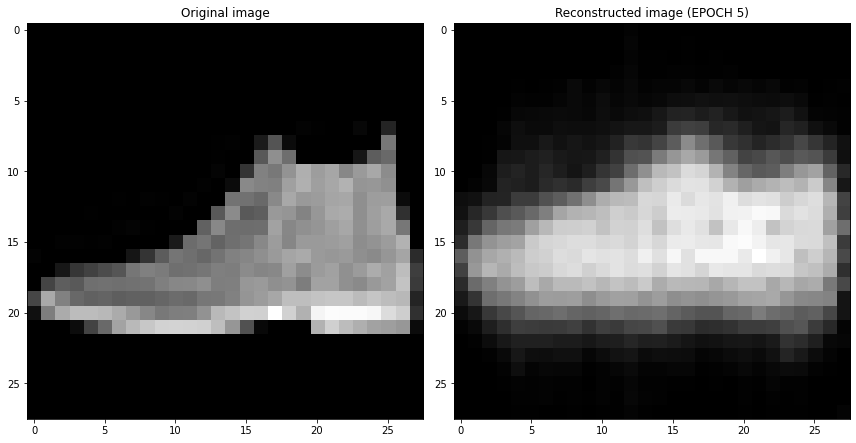

EPOCH 6/10
	 partial train loss (single batch): 0.034668
	 partial train loss (single batch): 0.035044
	 partial train loss (single batch): 0.038174
	 partial train loss (single batch): 0.034882
	 partial train loss (single batch): 0.036480
	 partial train loss (single batch): 0.035997
	 partial train loss (single batch): 0.036445
	 partial train loss (single batch): 0.035109
	 partial train loss (single batch): 0.035591
	 partial train loss (single batch): 0.036335
	 partial train loss (single batch): 0.034185
	 partial train loss (single batch): 0.037273
	 partial train loss (single batch): 0.038003
	 partial train loss (single batch): 0.037713
	 partial train loss (single batch): 0.033338
	 partial train loss (single batch): 0.035176
	 partial train loss (single batch): 0.036516
	 partial train loss (single batch): 0.035043
	 partial train loss (single batch): 0.034406
	 partial train loss (single batch): 0.036036
	 partial train loss (single batch): 0.034018
	 partial train loss (s

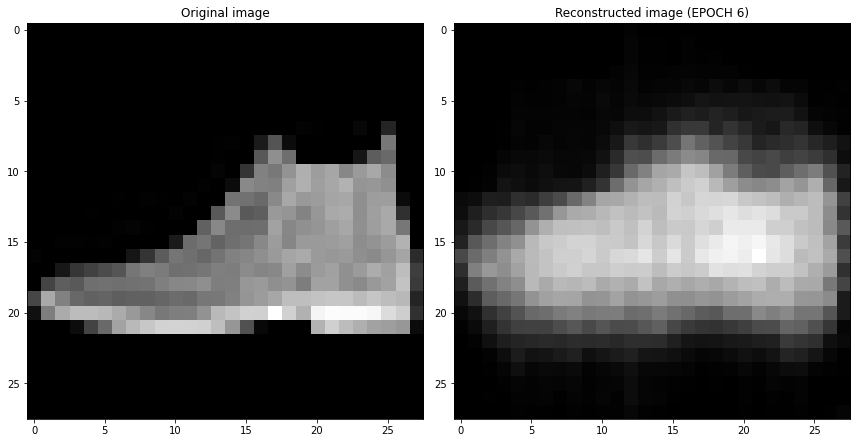

EPOCH 7/10
	 partial train loss (single batch): 0.036349
	 partial train loss (single batch): 0.034019
	 partial train loss (single batch): 0.034898
	 partial train loss (single batch): 0.034753
	 partial train loss (single batch): 0.035849
	 partial train loss (single batch): 0.034196
	 partial train loss (single batch): 0.034634
	 partial train loss (single batch): 0.031888
	 partial train loss (single batch): 0.035991
	 partial train loss (single batch): 0.033351
	 partial train loss (single batch): 0.034717
	 partial train loss (single batch): 0.036917
	 partial train loss (single batch): 0.034612
	 partial train loss (single batch): 0.033261
	 partial train loss (single batch): 0.035716
	 partial train loss (single batch): 0.036190
	 partial train loss (single batch): 0.035759
	 partial train loss (single batch): 0.034618
	 partial train loss (single batch): 0.034190
	 partial train loss (single batch): 0.035479
	 partial train loss (single batch): 0.036626
	 partial train loss (s

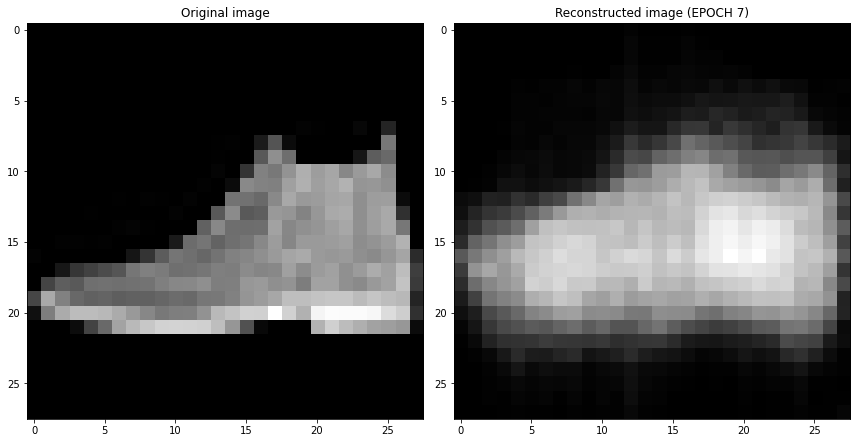

EPOCH 8/10
	 partial train loss (single batch): 0.034024
	 partial train loss (single batch): 0.034465
	 partial train loss (single batch): 0.034056
	 partial train loss (single batch): 0.033052
	 partial train loss (single batch): 0.034684
	 partial train loss (single batch): 0.033895
	 partial train loss (single batch): 0.034830
	 partial train loss (single batch): 0.034913
	 partial train loss (single batch): 0.033542
	 partial train loss (single batch): 0.033805
	 partial train loss (single batch): 0.033759
	 partial train loss (single batch): 0.033686
	 partial train loss (single batch): 0.033360
	 partial train loss (single batch): 0.032119
	 partial train loss (single batch): 0.034313
	 partial train loss (single batch): 0.035241
	 partial train loss (single batch): 0.034834
	 partial train loss (single batch): 0.034897
	 partial train loss (single batch): 0.035469
	 partial train loss (single batch): 0.032447
	 partial train loss (single batch): 0.036178
	 partial train loss (s

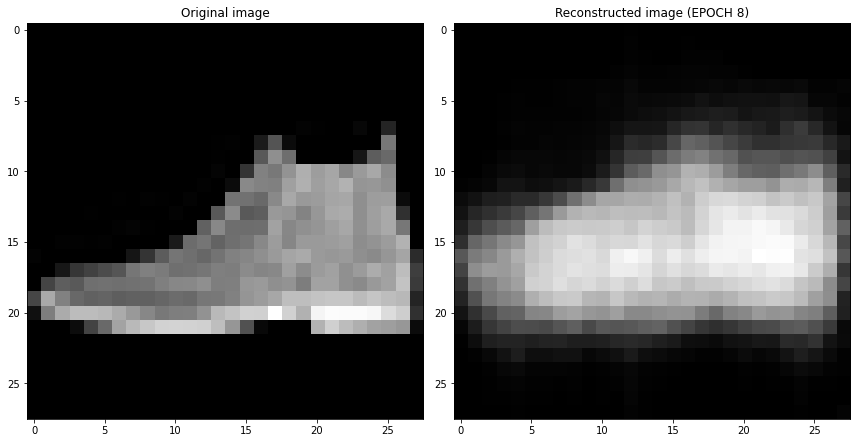

EPOCH 9/10
	 partial train loss (single batch): 0.033601
	 partial train loss (single batch): 0.032639
	 partial train loss (single batch): 0.034005
	 partial train loss (single batch): 0.031665
	 partial train loss (single batch): 0.032456
	 partial train loss (single batch): 0.032482
	 partial train loss (single batch): 0.033746
	 partial train loss (single batch): 0.036373
	 partial train loss (single batch): 0.031827
	 partial train loss (single batch): 0.032888
	 partial train loss (single batch): 0.033403
	 partial train loss (single batch): 0.031808
	 partial train loss (single batch): 0.031549
	 partial train loss (single batch): 0.033494
	 partial train loss (single batch): 0.035976
	 partial train loss (single batch): 0.031144
	 partial train loss (single batch): 0.033952
	 partial train loss (single batch): 0.033231
	 partial train loss (single batch): 0.034612
	 partial train loss (single batch): 0.032310
	 partial train loss (single batch): 0.034066
	 partial train loss (s

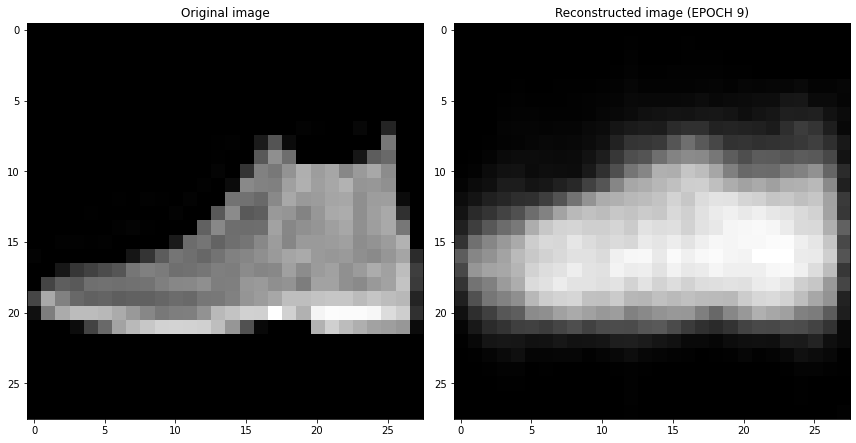

EPOCH 10/10
	 partial train loss (single batch): 0.032453
	 partial train loss (single batch): 0.031198
	 partial train loss (single batch): 0.031905
	 partial train loss (single batch): 0.030983
	 partial train loss (single batch): 0.033108
	 partial train loss (single batch): 0.035474
	 partial train loss (single batch): 0.033944
	 partial train loss (single batch): 0.032818
	 partial train loss (single batch): 0.034344
	 partial train loss (single batch): 0.032447
	 partial train loss (single batch): 0.033590
	 partial train loss (single batch): 0.033153
	 partial train loss (single batch): 0.032090
	 partial train loss (single batch): 0.031884
	 partial train loss (single batch): 0.032073
	 partial train loss (single batch): 0.032429
	 partial train loss (single batch): 0.033861
	 partial train loss (single batch): 0.032240
	 partial train loss (single batch): 0.032649
	 partial train loss (single batch): 0.032495
	 partial train loss (single batch): 0.031677
	 partial train loss (

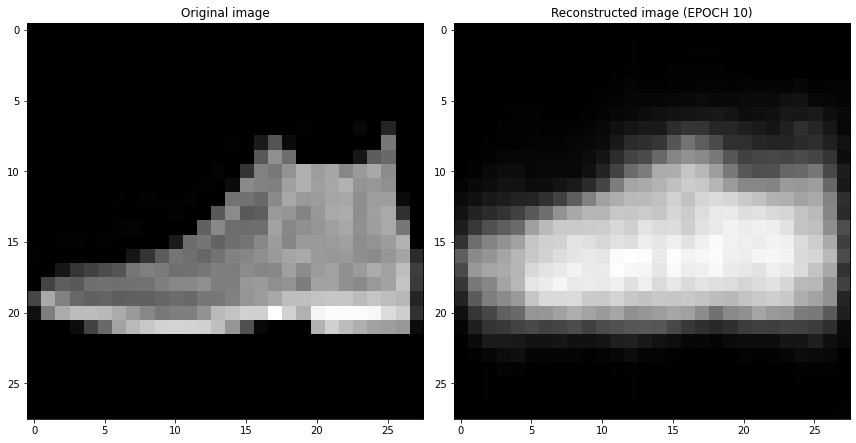

In [17]:

### Training cycle
num_epochs = 10
for epoch in range(num_epochs):
    print('EPOCH %d/%d' % (epoch + 1, num_epochs))
    ### Training (use the training function)
    train_epoch(
        encoder=encoder, 
        decoder=decoder, 
        device=device, 
        dataloader=train_dataloader, 
        loss_fn=loss_fn, 
        optimizer=optim)
    ### Validation  (use the testing function)
    val_loss = test_epoch(
        encoder=encoder, 
        decoder=decoder, 
        device=device, 
        dataloader=test_dataloader, 
        loss_fn=loss_fn)
    # Print Validationloss
    print('\n\n\t VALIDATION - EPOCH %d/%d - loss: %f\n\n' % (epoch + 1, num_epochs, val_loss))

    ### Plot progress
    # Get the output of a specific image (the test image at index 0 in this case)
    img = test_dataset[0][0].unsqueeze(0).to(device)
    encoder.eval()
    decoder.eval()
    with torch.no_grad():
        rec_img  = decoder(encoder(img))
    # Plot the reconstructed image
    fig, axs = plt.subplots(1, 2, figsize=(12,6))
    axs[0].imshow(img.cpu().squeeze().numpy(), cmap='gist_gray')
    axs[0].set_title('Original image')
    axs[1].imshow(rec_img.cpu().squeeze().numpy(), cmap='gist_gray')
    axs[1].set_title('Reconstructed image (EPOCH %d)' % (epoch + 1))
    plt.tight_layout()
    plt.pause(0.1)
    # Save figures
    os.makedirs('autoencoder_progress_%d_features' % encoded_space_dim, exist_ok=True)
    fig.savefig('autoencoder_progress_%d_features/epoch_%d.png' % (encoded_space_dim, epoch + 1))
    plt.show()
    plt.close()

    # Save network parameters
    torch.save(encoder.state_dict(), 'encoder_params.pth')
    torch.save(decoder.state_dict(), 'decoder_params.pth')


    # NOTE: Remember to save also the parameters of the optimizer if you want to restore and continue the training

# Network Analysis

If you have a previously saved network, restore the network parameters.

In [18]:
# Load network parameters
encoder.load_state_dict(torch.load('encoder_params.pth'))
decoder.load_state_dict(torch.load('decoder_params.pth'))

<All keys matched successfully>

The encoder can be used to evaluate the latent space values for each of the test images. Since we used an encoded space dimension of 2, the encoder maps an entire image to just 2 floating point numbers.

We also save the corresponding label to show how each digit is mapped in the encoded space.

In [19]:
### Get the encoded representation of the test samples
encoded_samples = []
for sample in tqdm(test_dataset):
    img = sample[0].unsqueeze(0).to(device)
    label = sample[1]
    # Encode image
    encoder.eval()
    with torch.no_grad():
        encoded_img  = encoder(img)
    # Append to list
    encoded_img = encoded_img.flatten().cpu().numpy()
    encoded_sample = {f"Enc. Variable {i}": enc for i, enc in enumerate(encoded_img)}
    encoded_sample['label'] = label
    encoded_samples.append(encoded_sample)

100%|██████████| 10000/10000 [00:06<00:00, 1445.96it/s]


For convenience (not required), convert the result to a table format (`pandas.DataFrame`):

In [20]:
# Convert to a dataframe
encoded_samples = pd.DataFrame(encoded_samples)
encoded_samples

,Enc. Variable 0,Enc. Variable 1,label
0,-3.590631,-17.083778,9
1,1.582924,11.859848,2
2,-39.374508,9.009667,1
3,-40.544147,5.058730,1
4,-4.240509,-1.553587,6
...,...,...,...
9995,13.016418,-16.334251,9
9996,-32.811096,0.085763,1
9997,-11.624472,-0.560444,8
9998,-48.310017,7.038786,1


This graph shows where each input image is mapped in the encoded space. Since we have just 2 encoded variables, we can easily plot them in a bidimensional space. 

In [21]:
import plotly.express as px
px.scatter(encoded_samples, x='Enc. Variable 0', y='Enc. Variable 1', color=[label_names[l] for l in encoded_samples.label.to_numpy()], opacity=0.7)

As you can see from the graph, even if we never used the labels (i.e. the id of the class in the image) during the training, the network has been able to clusterize quite well the different classes.

> **NOTE**
> 
> The encoded space may have many more variables. In this case you can still have a visual representation of the encoded space by applying a dimensionality reduction method, such as:
- [Principal Component Analysis (PCA)](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html)
- [t-distributed Stochastic Neighbor Embedding (t-SNE)](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html)




While the encoder is able to map the image to the encoded space, the decoder can do the opposite, generating an image given the corresponding latent space values.

The latent space can also be manually customized, like in the following example, where we generate images with the decoder by providing custom latent space variables.

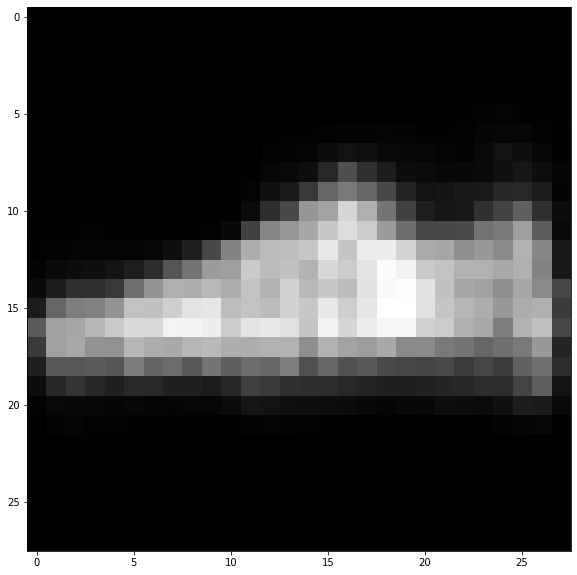

In [22]:
if encoded_space_dim == 2:
    # Generate a custom sample
    custom_encoded_sample = [-6, -30.0]
    encoded_value = torch.tensor(custom_encoded_sample).float().unsqueeze(0).to(device)

    # Decode sample
    decoder.eval()
    with torch.no_grad():
        generated_img  = decoder(encoded_value)

    plt.figure(figsize=(12,10))
    plt.imshow(generated_img.squeeze().cpu().numpy(), cmap='gist_gray')
    plt.show()

# Further insights on PCA and t-SNE

Let's do the same training again, with encoded dimension equal to 10.

Selected device: cuda
EPOCH 1/10
	 partial train loss (single batch): 0.179494
	 partial train loss (single batch): 0.181603
	 partial train loss (single batch): 0.180025
	 partial train loss (single batch): 0.178158
	 partial train loss (single batch): 0.182383
	 partial train loss (single batch): 0.177239
	 partial train loss (single batch): 0.178596
	 partial train loss (single batch): 0.177731
	 partial train loss (single batch): 0.178102
	 partial train loss (single batch): 0.174652
	 partial train loss (single batch): 0.179585
	 partial train loss (single batch): 0.180975
	 partial train loss (single batch): 0.173913
	 partial train loss (single batch): 0.174123
	 partial train loss (single batch): 0.174520
	 partial train loss (single batch): 0.175449
	 partial train loss (single batch): 0.178706
	 partial train loss (single batch): 0.176363
	 partial train loss (single batch): 0.176311
	 partial train loss (single batch): 0.179125
	 partial train loss (single batch): 0.175773
	

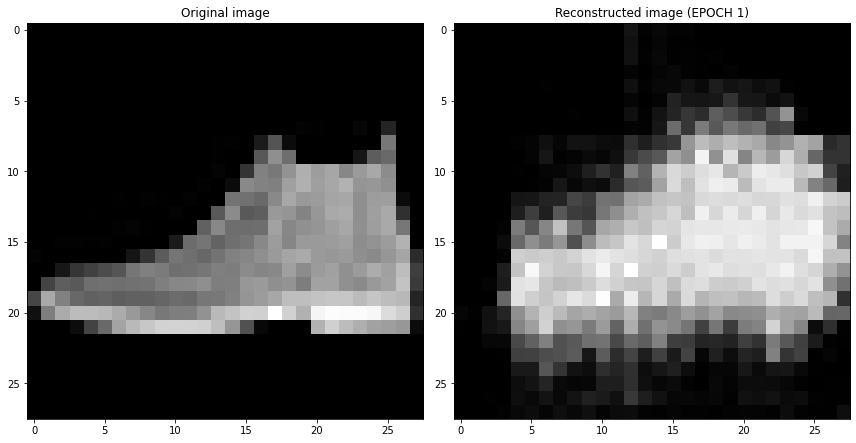

EPOCH 2/10
	 partial train loss (single batch): 0.063205
	 partial train loss (single batch): 0.061259
	 partial train loss (single batch): 0.062998
	 partial train loss (single batch): 0.057871
	 partial train loss (single batch): 0.061722
	 partial train loss (single batch): 0.059884
	 partial train loss (single batch): 0.059979
	 partial train loss (single batch): 0.059136
	 partial train loss (single batch): 0.058085
	 partial train loss (single batch): 0.059283
	 partial train loss (single batch): 0.059368
	 partial train loss (single batch): 0.057157
	 partial train loss (single batch): 0.060871
	 partial train loss (single batch): 0.058593
	 partial train loss (single batch): 0.058160
	 partial train loss (single batch): 0.061128
	 partial train loss (single batch): 0.059113
	 partial train loss (single batch): 0.058335
	 partial train loss (single batch): 0.056541
	 partial train loss (single batch): 0.059405
	 partial train loss (single batch): 0.058310
	 partial train loss (s

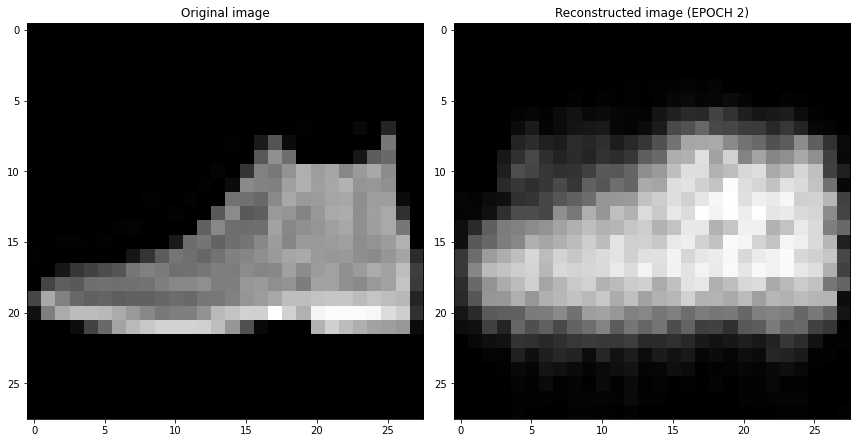

EPOCH 3/10
	 partial train loss (single batch): 0.042074
	 partial train loss (single batch): 0.042094
	 partial train loss (single batch): 0.042281
	 partial train loss (single batch): 0.043015
	 partial train loss (single batch): 0.041929
	 partial train loss (single batch): 0.040479
	 partial train loss (single batch): 0.044654
	 partial train loss (single batch): 0.042483
	 partial train loss (single batch): 0.043150
	 partial train loss (single batch): 0.039680
	 partial train loss (single batch): 0.042813
	 partial train loss (single batch): 0.042990
	 partial train loss (single batch): 0.040841
	 partial train loss (single batch): 0.043365
	 partial train loss (single batch): 0.043175
	 partial train loss (single batch): 0.043202
	 partial train loss (single batch): 0.040743
	 partial train loss (single batch): 0.042152
	 partial train loss (single batch): 0.040571
	 partial train loss (single batch): 0.042574
	 partial train loss (single batch): 0.041136
	 partial train loss (s

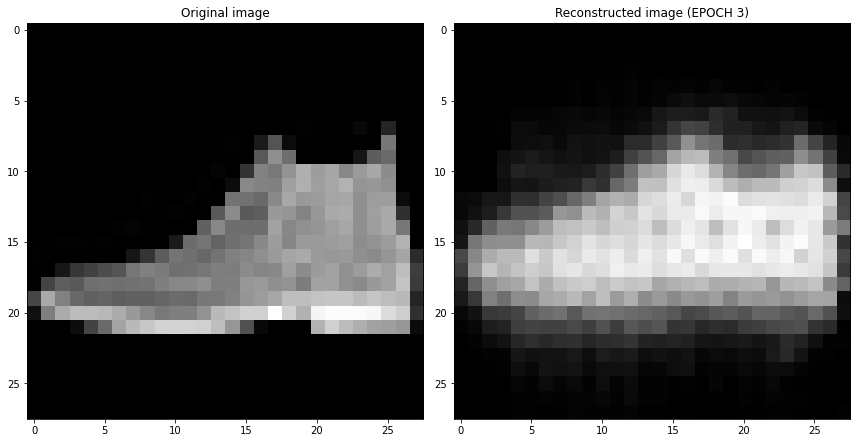

EPOCH 4/10
	 partial train loss (single batch): 0.039531
	 partial train loss (single batch): 0.039113
	 partial train loss (single batch): 0.039815
	 partial train loss (single batch): 0.038237
	 partial train loss (single batch): 0.038799
	 partial train loss (single batch): 0.038212
	 partial train loss (single batch): 0.037938
	 partial train loss (single batch): 0.041007
	 partial train loss (single batch): 0.038765
	 partial train loss (single batch): 0.036335
	 partial train loss (single batch): 0.040884
	 partial train loss (single batch): 0.037802
	 partial train loss (single batch): 0.036242
	 partial train loss (single batch): 0.041477
	 partial train loss (single batch): 0.039540
	 partial train loss (single batch): 0.040438
	 partial train loss (single batch): 0.039100
	 partial train loss (single batch): 0.039610
	 partial train loss (single batch): 0.037812
	 partial train loss (single batch): 0.040182
	 partial train loss (single batch): 0.036595
	 partial train loss (s

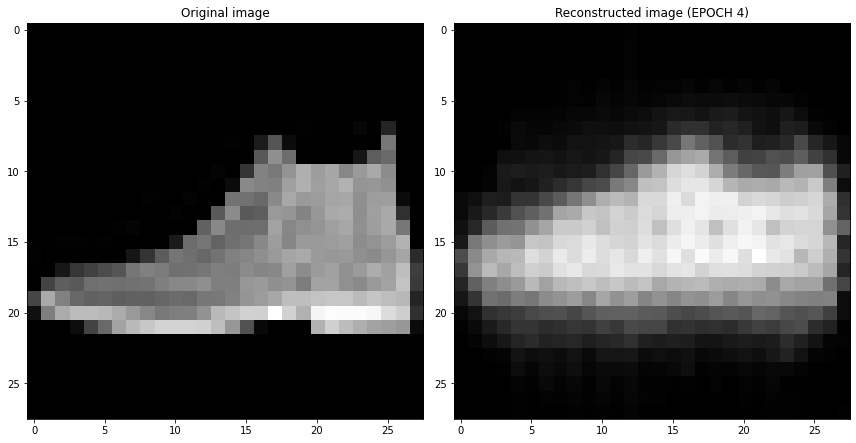

EPOCH 5/10
	 partial train loss (single batch): 0.036281
	 partial train loss (single batch): 0.037285
	 partial train loss (single batch): 0.035959
	 partial train loss (single batch): 0.037157
	 partial train loss (single batch): 0.038809
	 partial train loss (single batch): 0.037702
	 partial train loss (single batch): 0.036434
	 partial train loss (single batch): 0.037807
	 partial train loss (single batch): 0.038628
	 partial train loss (single batch): 0.037109
	 partial train loss (single batch): 0.039478
	 partial train loss (single batch): 0.038713
	 partial train loss (single batch): 0.036352
	 partial train loss (single batch): 0.035222
	 partial train loss (single batch): 0.035908
	 partial train loss (single batch): 0.038679
	 partial train loss (single batch): 0.036260
	 partial train loss (single batch): 0.038036
	 partial train loss (single batch): 0.041860
	 partial train loss (single batch): 0.038611
	 partial train loss (single batch): 0.036805
	 partial train loss (s

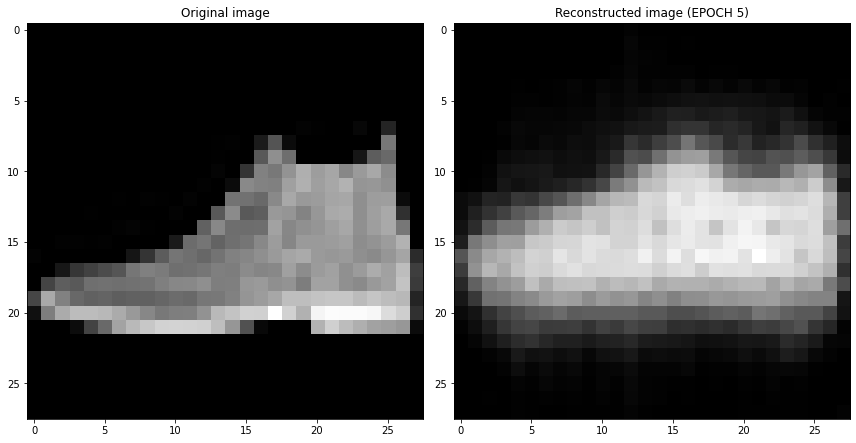

EPOCH 6/10
	 partial train loss (single batch): 0.034683
	 partial train loss (single batch): 0.034951
	 partial train loss (single batch): 0.038146
	 partial train loss (single batch): 0.034790
	 partial train loss (single batch): 0.036407
	 partial train loss (single batch): 0.035943
	 partial train loss (single batch): 0.036301
	 partial train loss (single batch): 0.034961
	 partial train loss (single batch): 0.035532
	 partial train loss (single batch): 0.036295
	 partial train loss (single batch): 0.034231
	 partial train loss (single batch): 0.037283
	 partial train loss (single batch): 0.037885
	 partial train loss (single batch): 0.037546
	 partial train loss (single batch): 0.033268
	 partial train loss (single batch): 0.035197
	 partial train loss (single batch): 0.036586
	 partial train loss (single batch): 0.035034
	 partial train loss (single batch): 0.034360
	 partial train loss (single batch): 0.035959
	 partial train loss (single batch): 0.034093
	 partial train loss (s

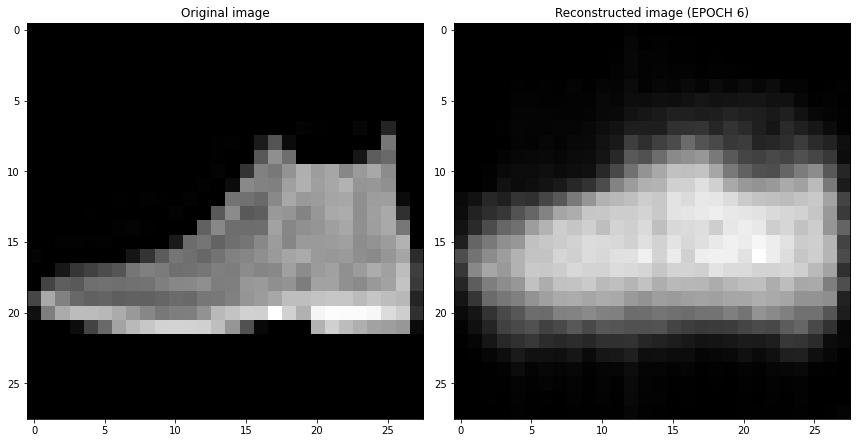

EPOCH 7/10
	 partial train loss (single batch): 0.036283
	 partial train loss (single batch): 0.033984
	 partial train loss (single batch): 0.034765
	 partial train loss (single batch): 0.034700
	 partial train loss (single batch): 0.035850
	 partial train loss (single batch): 0.034159
	 partial train loss (single batch): 0.034463
	 partial train loss (single batch): 0.031825
	 partial train loss (single batch): 0.035784
	 partial train loss (single batch): 0.033199
	 partial train loss (single batch): 0.034846
	 partial train loss (single batch): 0.036644
	 partial train loss (single batch): 0.034510
	 partial train loss (single batch): 0.033190
	 partial train loss (single batch): 0.035556
	 partial train loss (single batch): 0.036179
	 partial train loss (single batch): 0.035394
	 partial train loss (single batch): 0.034583
	 partial train loss (single batch): 0.033987
	 partial train loss (single batch): 0.035480
	 partial train loss (single batch): 0.036442
	 partial train loss (s

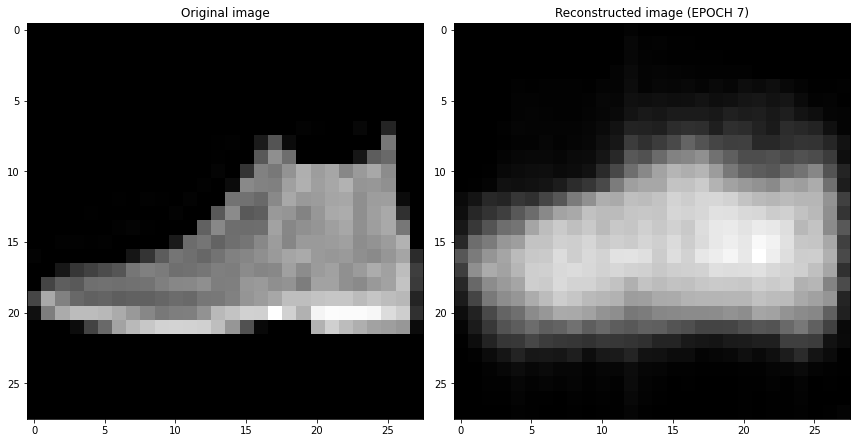

EPOCH 8/10
	 partial train loss (single batch): 0.033775
	 partial train loss (single batch): 0.034254
	 partial train loss (single batch): 0.033919
	 partial train loss (single batch): 0.032922
	 partial train loss (single batch): 0.034369
	 partial train loss (single batch): 0.033587
	 partial train loss (single batch): 0.034661
	 partial train loss (single batch): 0.034618
	 partial train loss (single batch): 0.033276
	 partial train loss (single batch): 0.033471
	 partial train loss (single batch): 0.033754
	 partial train loss (single batch): 0.033553
	 partial train loss (single batch): 0.033318
	 partial train loss (single batch): 0.032013
	 partial train loss (single batch): 0.034137
	 partial train loss (single batch): 0.035259
	 partial train loss (single batch): 0.034734
	 partial train loss (single batch): 0.034794
	 partial train loss (single batch): 0.035489
	 partial train loss (single batch): 0.032187
	 partial train loss (single batch): 0.035894
	 partial train loss (s

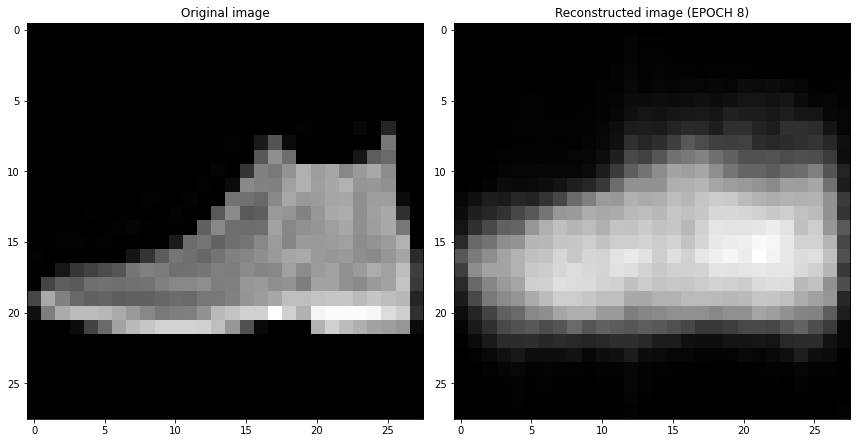

EPOCH 9/10
	 partial train loss (single batch): 0.033478
	 partial train loss (single batch): 0.032583
	 partial train loss (single batch): 0.033822
	 partial train loss (single batch): 0.031609
	 partial train loss (single batch): 0.032263
	 partial train loss (single batch): 0.032593
	 partial train loss (single batch): 0.033755
	 partial train loss (single batch): 0.036149
	 partial train loss (single batch): 0.031876
	 partial train loss (single batch): 0.032624
	 partial train loss (single batch): 0.033533
	 partial train loss (single batch): 0.031735
	 partial train loss (single batch): 0.031608
	 partial train loss (single batch): 0.033384
	 partial train loss (single batch): 0.035875
	 partial train loss (single batch): 0.030905
	 partial train loss (single batch): 0.033809
	 partial train loss (single batch): 0.033026
	 partial train loss (single batch): 0.034712
	 partial train loss (single batch): 0.032392
	 partial train loss (single batch): 0.034087
	 partial train loss (s

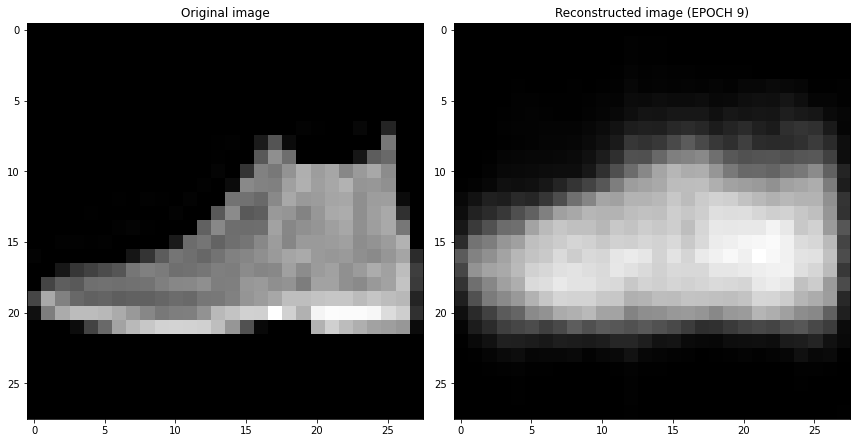

EPOCH 10/10
	 partial train loss (single batch): 0.032630
	 partial train loss (single batch): 0.031314
	 partial train loss (single batch): 0.032189
	 partial train loss (single batch): 0.030943
	 partial train loss (single batch): 0.033167
	 partial train loss (single batch): 0.035350
	 partial train loss (single batch): 0.034050
	 partial train loss (single batch): 0.033076
	 partial train loss (single batch): 0.034244
	 partial train loss (single batch): 0.032804
	 partial train loss (single batch): 0.033286
	 partial train loss (single batch): 0.032780
	 partial train loss (single batch): 0.031533
	 partial train loss (single batch): 0.031726
	 partial train loss (single batch): 0.032048
	 partial train loss (single batch): 0.032428
	 partial train loss (single batch): 0.033883
	 partial train loss (single batch): 0.032250
	 partial train loss (single batch): 0.032558
	 partial train loss (single batch): 0.032682
	 partial train loss (single batch): 0.031689
	 partial train loss (

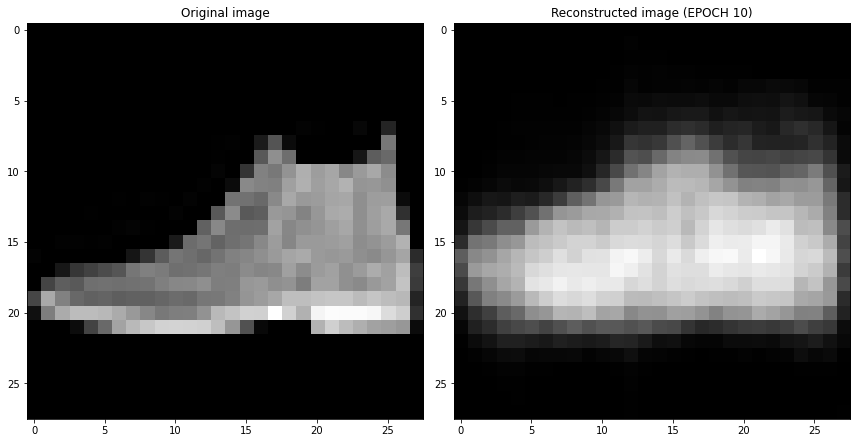

In [23]:
### Set the random seed for reproducible results
torch.manual_seed(0)

### Initialize the two networks
encoded_space_dim = 10  # this is the only line we change!
encoder = Encoder(encoded_space_dim=encoded_space_dim)
decoder = Decoder(encoded_space_dim=encoded_space_dim)


### Define the loss function
loss_fn = torch.nn.MSELoss()

### Define an optimizer (both for the encoder and the decoder!)
lr = 5e-4 # Learning rate
params_to_optimize = [
    {'params': encoder.parameters()},
    {'params': decoder.parameters()}
]
optim = torch.optim.Adam(params_to_optimize, lr=lr, weight_decay=1e-5)

# Check if the GPU is available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Selected device: {device}')

# Move both the encoder and the decoder to the selected device
encoder.to(device)
decoder.to(device)


### Training cycle
num_epochs = 10
for epoch in range(num_epochs):
    print('EPOCH %d/%d' % (epoch + 1, num_epochs))
    ### Training (use the training function)
    train_epoch(
        encoder=encoder, 
        decoder=decoder, 
        device=device, 
        dataloader=train_dataloader, 
        loss_fn=loss_fn, 
        optimizer=optim)
    ### Validation  (use the testing function)
    val_loss = test_epoch(
        encoder=encoder, 
        decoder=decoder, 
        device=device, 
        dataloader=test_dataloader, 
        loss_fn=loss_fn)
    # Print Validationloss
    print('\n\n\t VALIDATION - EPOCH %d/%d - loss: %f\n\n' % (epoch + 1, num_epochs, val_loss))

    ### Plot progress
    # Get the output of a specific image (the test image at index 0 in this case)
    img = test_dataset[0][0].unsqueeze(0).to(device)
    encoder.eval()
    decoder.eval()
    with torch.no_grad():
        rec_img  = decoder(encoder(img))
    # Plot the reconstructed image
    fig, axs = plt.subplots(1, 2, figsize=(12,6))
    axs[0].imshow(img.cpu().squeeze().numpy(), cmap='gist_gray')
    axs[0].set_title('Original image')
    axs[1].imshow(rec_img.cpu().squeeze().numpy(), cmap='gist_gray')
    axs[1].set_title('Reconstructed image (EPOCH %d)' % (epoch + 1))
    plt.tight_layout()
    plt.pause(0.1)
    # Save figures
    os.makedirs('autoencoder_progress_%d_features' % encoded_space_dim, exist_ok=True)
    fig.savefig('autoencoder_progress_%d_features/epoch_%d.jpg' % (encoded_space_dim, epoch + 1))
    plt.show()
    plt.close()

In [24]:
### Get the encoded representation of the test samples
encoded_samples = []
for sample in tqdm(test_dataset):
    img = sample[0].unsqueeze(0).to(device)
    label = sample[1]
    # Encode image
    encoder.eval()
    with torch.no_grad():
        encoded_img  = encoder(img)
    # Append to list
    encoded_img = encoded_img.flatten().cpu().numpy()
    encoded_sample = {f"Enc. Variable {i}": enc for i, enc in enumerate(encoded_img)}
    encoded_sample['label'] = label
    encoded_samples.append(encoded_sample)

encoded_samples = pd.DataFrame(encoded_samples)
encoded_samples

100%|██████████| 10000/10000 [00:13<00:00, 732.70it/s]


,Enc. Variable 0,Enc. Variable 1,label
0,-4.932986,-16.903471,9
1,3.053735,11.565152,2
2,-36.260574,9.711349,1
3,-39.050922,6.039440,1
4,-3.828065,-0.635818,6
...,...,...,...
9995,12.958740,-16.625410,9
9996,-32.315453,0.752094,1
9997,-10.467270,-0.146134,8
9998,-45.423855,8.079533,1


**How can we visualize data?** we like 2D-3D plots for intuition!

PCA and tSNE come into play.

In [25]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
encoded_samples_reduced_PCA = pca.fit_transform(encoded_samples)
encoded_samples_reduced_PCA

array([[-14.33648738,  -6.70598736],
       [  2.27278587,  18.18000363],
       [ 27.09699642, -12.25065356],
       ...,
       [  1.8167305 ,   0.40100587],
       [ 31.96799784, -20.14342443],
       [-12.42584782,  -8.67467863]])

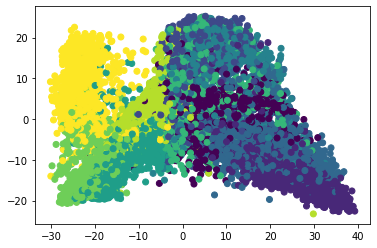

In [26]:
plt.scatter(encoded_samples_reduced_PCA[:,0], encoded_samples_reduced_PCA[:,1], c=encoded_samples.label.to_numpy())

/home/irong/nn_deep_learning_2021/dl_env/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/home/irong/nn_deep_learning_2021/dl_env/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



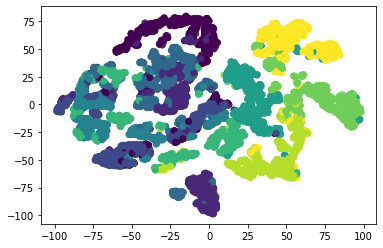

In [27]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2)
encoded_samples_reduced_TSNE = tsne.fit_transform(encoded_samples)
plt.scatter(encoded_samples_reduced_TSNE[:,0], encoded_samples_reduced_TSNE[:,1], c=encoded_samples.label.to_numpy())

Given a point cloud:
*   **PCA** is like taking a snapshot from a different perspective/angle (linear only)
*   **tSNE** is like taking a snapshot from a different perspective/angle and at the same time stretching the space (non-linear)


**Autoencoders** can be used to solve a variety of different tasks!


*   Denoising images: add random noise to the training transform and want to predict the denoised image
*   Filling holes: add random holes in the image and predict the filled image
*   Image Generation: via Variational Autoencoders VAEs,...

